In [1]:
%load_ext autoreload
%autoreload 2

import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np
import jax.random as random
import pickle
import seaborn as sns 
from statannot import add_stat_annotation
import scipy.stats as stats
import umap
import tqdm
from matplotlib.pyplot import cm
import matplotlib.pyplot as plt

## Set this to disable JAX from preallocating memory
# import os
# os.environ["XLA_PYTHON_CLIENT_PREALLOCATE"] = "false"

from datasets import *
from training_setup import *
from training import *
from utils import *
from analysis_utils import *

In [2]:
DATA_PATH="./"
SAVE_PATH="./"
MODEL_PATH="./"

In [3]:
df = pd.read_csv(f"{DATA_PATH}/A549_EMT_heldout_1d_tp_normalized.csv", index_col=0)
total_timepoints = len(df["time"].unique())
timepoint_map={k:v for k,v in zip(np.arange(total_timepoints), sorted(df["time"].unique()))}
rev_timepoint_map={k:v for k,v in zip(sorted(df["time"].unique()), np.arange(total_timepoints))}
df["time"] = df["time"].map(rev_timepoint_map)

train_tps_idx = [0,1,3,4]
val_tps_idx = [2]

train_tps = train_tps_idx
val_tps = val_tps_idx

timepoints_sorted =  sorted(df["time"].unique().tolist())
    
train_data = df[df["time"].isin(train_tps)].iloc[:,:]
val_data = df[df["time"].isin(val_tps)].iloc[:,:]

z_score=True

if z_score:
    train_data = z_score_norm(train_data)
    val_data = z_score_norm(val_data)

train_data.shape, val_data.shape, train_data["time"].unique(), val_data["time"].unique()

((2345, 2001), (788, 2001), array([3, 4, 1, 0]), array([2]))

In [4]:
df["time"].unique()

array([3, 4, 1, 0, 2])

In [20]:
#tuned params
train=False

vae_latent_dim=50
vae_enc_hidden_dim=vae_dec_hidden_dim=[256,128]
vae_input_dim=train_data.iloc[:,:-1].shape[-1]
t_dim=16
lr=1e-4
vae_lr=1e-4
ferryman_lr=1e-4

dec_hidden_dim=200
td_sched=2
vae_epochs=100
epochs=10
num_sde=10
paths_reuse=5
steps_num=100
batch_size=64
vae_batch_size=64
death_importance_rate=100
ferryman_hidden_dim=64
vae_t_dim=8
f_val=2


if train:
    
    train_dataset = Input_Dataset(x=train_data, meta=None, meta_celltype_column=None, splitting_births_frac=0.9,
                            steps_num=steps_num, val_split=False, death_importance_rate=death_importance_rate, f_val=f_val)

    ts = Training_Setup(dataset=train_dataset, dataset_name="EMT", hidden_dim=[dec_hidden_dim, dec_hidden_dim], 
                        dec_hidden_size=[dec_hidden_dim,dec_hidden_dim,1],vae_epochs=vae_epochs, 
                        epochs=epochs,  num_sde=num_sde, paths_reuse=paths_reuse, reality_coefficient=0.2, 
                        ipf_mask_dead=True, t_dim=t_dim, batch_size=batch_size, vae_batch_size=vae_batch_size,
                        vae_input_dim=vae_input_dim, vae_enc_hidden_dim=vae_enc_hidden_dim, vae_dec_hidden_dim=vae_dec_hidden_dim,
                        vae_latent_dim=vae_latent_dim,ferryman_hidden_dim=[ferryman_hidden_dim, ferryman_hidden_dim])

    tr = Trainer(dataset=train_dataset, ts=ts,key=random.PRNGKey(0), lr=lr, vae_lr=vae_lr, ferryman_lr=ferryman_lr, ferryman_coeff=1)

    tr_model = tr.train(td_schedule=[1]*td_sched, project_name="EMT")

    train_recon, train_latent, val_recon, val_latent = get_model_latents(train_data, val_data, ts, tr_model)
 

else:
    train_dataset = Input_Dataset(x=train_data, meta=None, meta_celltype_column=None, splitting_births_frac=0.9,
                            steps_num=steps_num, val_split=False, death_importance_rate=death_importance_rate, f_val=f_val)

    ts = Training_Setup(dataset=train_dataset, dataset_name="EMT", hidden_dim=[dec_hidden_dim, dec_hidden_dim], 
                        dec_hidden_size=[dec_hidden_dim,dec_hidden_dim,1],vae_epochs=vae_epochs, 
                        epochs=epochs,  num_sde=num_sde, paths_reuse=paths_reuse, reality_coefficient=0.2, 
                        ipf_mask_dead=True, t_dim=t_dim, batch_size=batch_size, vae_batch_size=vae_batch_size,
                        vae_input_dim=vae_input_dim, vae_enc_hidden_dim=vae_enc_hidden_dim, vae_dec_hidden_dim=vae_dec_hidden_dim,
                        vae_latent_dim=vae_latent_dim,ferryman_hidden_dim=[ferryman_hidden_dim, ferryman_hidden_dim])

    tr = Trainer(dataset=train_dataset, ts=ts,key=random.PRNGKey(0), lr=lr, vae_lr=vae_lr, ferryman_lr=ferryman_lr, ferryman_coeff=1)

    with open(f"{MODEL_PATH}/train_emt_1d_heldout_z_scored.pkl","rb") as f:
        model_params = pickle.load(f)
        
    tr_model = tr
    tr_model.vae_params = model_params["vae_params"]
    tr_model.training_setup.state[1]["forward"] = model_params["forward"]
    tr_model.training_setup.state[1]["backward"] = model_params["backward"]
    tr_model.training_setup.state[1]["ferryman"] = model_params["ferryman"]
    train_recon, train_latent, val_recon, val_latent = get_model_latents(train_data, val_data, ts, tr_model)
    train_dataset.update_data_info(train_latent, None)
    ts.sde.killer = train_dataset.killing_function()

### Result analyses

1. Visualize VAE latents and reconstructed cell

In [7]:
mapper = umap.UMAP().fit(val_latent.values[:,:-1])
val_pred_latent = mapper.transform(val_latent.values[:,:-1])
mapper = umap.UMAP().fit(val_data.values[:,:-1])
val_preg_orig = mapper.transform(val_data.values[:,:-1])
val_pred_logits = mapper.transform(val_recon.values[:,:-1])

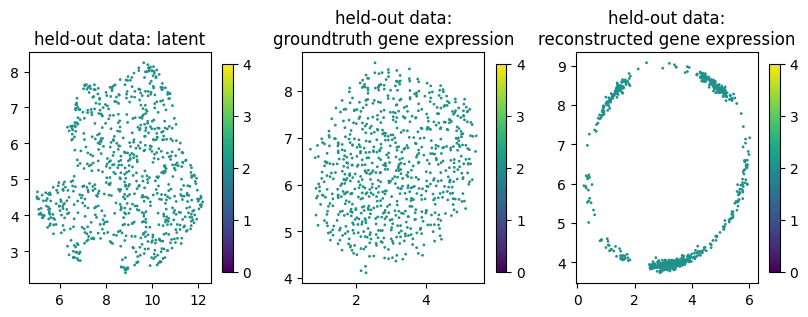

In [8]:
fig, (ax1,ax2,ax3) = plt.subplots(1,3,figsize = (10, 3))

sax1 = ax1.scatter(val_pred_latent[:,0], val_pred_latent[:,1], s = 1, c = val_latent.values[:,-1], vmin = min(timepoints_sorted), vmax = max(timepoints_sorted),cmap="viridis")
plt.colorbar(sax1, shrink = 0.9)
ax1.set_title("held-out data: latent")

sax2 = ax2.scatter(val_preg_orig[:,0], val_preg_orig[:,1], s = 1, c = val_data.values[:,-1], vmin = min(timepoints_sorted), vmax = max(timepoints_sorted),cmap="viridis")
plt.colorbar(sax2, shrink = 0.9)
ax2.set_title("held-out data:\ngroundtruth gene expression")

sax3 = ax3.scatter(val_pred_logits[:,0], val_pred_logits[:,1], s = 1, c = val_recon.values[:,-1], vmin = min(timepoints_sorted), vmax = max(timepoints_sorted),cmap="viridis")
plt.colorbar(sax3, shrink = 0.9)
ax3.set_title("held-out data:\nreconstructed gene expression")

plt.show()

2. Relative population changes

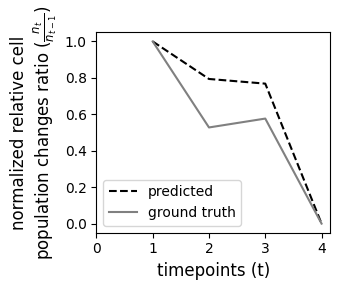

In [22]:
pred_trajectories, pred_trajectories_alive, timepoints, timepoints_alive, statuses, birth_statuses = get_latent_trajectories(train_dataset,train_latent, timepoints_sorted, tr_model, ts, max_size=2000,t_0_orig=train_tps[0])
all_mass = df["time"].value_counts().sort_index().values
predicted_status = np.array([(statuses[int(tr_model.dataset.cells_time(timepoints_sorted[i])*steps_num)].sum().item())/(statuses[int(tr_model.dataset.cells_time(timepoints_sorted[i-1])*steps_num)].sum().item()) for i in range(1,len(timepoints_sorted))])
predicted_status_norm = (predicted_status - predicted_status.min())/(predicted_status.max() - predicted_status.min())
groundtruth_status_norm = all_mass[1:]/all_mass[:-1]
groundtruth_status_norm = (groundtruth_status_norm - groundtruth_status_norm.min())/(groundtruth_status_norm.max()-groundtruth_status_norm.min())

fig, ax = plt.subplots(figsize = (3.5, 3))

plt.plot(list(timepoint_map.keys())[1:], predicted_status_norm,label="predicted", color="black", ls='--')
plt.plot(list(timepoint_map.keys())[1:], groundtruth_status_norm, label="ground truth", color="grey")

plt.xticks(timepoints_sorted)
plt.xlabel("timepoints (t)", fontdict={"size":12})
plt.ylabel(f"normalized relative cell\npopulation changes ratio "+r"($\frac{n_{t}}{n_{t-1}})$", fontdict={"size":12})

plt.legend(loc="lower left")
plt.title(" ")
plt.tight_layout()
# plt.savefig(f"{SAVE_PATH}/relative_cell_population_changes_emt.png", dpi=300)
plt.show()

3. Reconstructed trajectories

In [23]:
# for held-out timepoints
pred_trajectories_alive_w_time = pd.DataFrame(pred_trajectories_alive)
pred_trajectories_alive_w_time["time"] = timepoints_alive
test_trajs = get_test_trajs(pred_trajectories_alive_w_time, val_data["time"].to_list())

pred_trajectories_w_time = pd.DataFrame(pred_trajectories)
pred_trajectories_w_time["time"] = timepoints
test_trajs_all = get_test_trajs(pred_trajectories_w_time, val_data["time"].to_list())

In [24]:
# for held-out timepoints
recon_data = get_reconstructed_trajectory(pred_trajectories_alive, val_data, vae_input_dim, vae_dec_hidden_dim,vae_latent_dim, tr_model, timepoints_alive)

mapper = umap.UMAP(random_state=42, n_components=2)
all_true_umap = mapper.fit_transform(pd.concat([train_data, val_data]).iloc[:,:-1].values)
val_true_umap = mapper.transform(val_data.iloc[:,:-1].values)

val_recon_w_time = pd.DataFrame(recon_data)
val_recon_w_time["time"] = timepoints_alive
test_recon_trajs = get_test_trajs(val_recon_w_time, val_data["time"].to_list())
pred_recon_umap = mapper.transform(test_recon_trajs.iloc[:,:-1].values)

pred_recon_all_umap = mapper.transform(val_recon_w_time.iloc[:,:-1].values)

Text(0.5, 1.0, 'drift predicted:\nreconstructed')

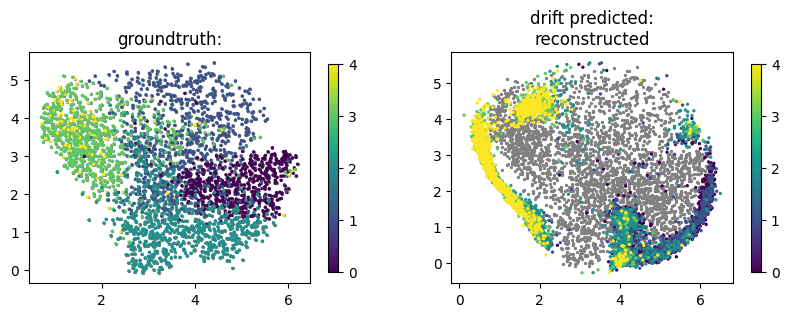

In [25]:
fig, (ax1,ax2) = plt.subplots(1,2,figsize = (10, 3))

ax1.scatter(all_true_umap[:,0], all_true_umap[:,1], s = 2, c="grey")
sax1 = ax1.scatter(all_true_umap[:,0], all_true_umap[:,1], s = 2, c = pd.concat([train_data, val_data]).iloc[:,-1].values, vmin = min(timepoints_sorted), vmax = max(timepoints_sorted),cmap="viridis")
plt.colorbar(sax1, shrink = 0.9)
ax1.set_title("groundtruth:")

ax2.scatter(all_true_umap[:,0], all_true_umap[:,1], s = 2, c="grey")
sax2 = ax2.scatter(pred_recon_all_umap[:,0], pred_recon_all_umap[:,1], s = 2, c = val_recon_w_time.iloc[:,-1], vmin = min(timepoints_sorted), vmax = max(timepoints_sorted),cmap="viridis")
plt.colorbar(sax2, shrink = 0.9) 
ax2.set_title("drift predicted:\nreconstructed")

In [26]:
train_val_latent = pd.concat([train_latent, val_latent])

mapper = umap.UMAP(random_state=42, n_components=2)
all_true_umap = mapper.fit_transform(pd.concat([train_data, val_data]).iloc[:,:-1].values)
all_true_umap_df =  pd.DataFrame(all_true_umap)
all_true_umap_df["time"] = pd.concat([train_data, val_data]).iloc[:,-1].values

params = tr.training_setup.state[1]
score = broadcast(lambda model, params: partial(tr.training_setup.score(model), params), tr.training_setup.model, params)
params_ferryman = tr_model.training_setup.state[1][FERRYMAN]
eval_ferryman= partial(tr_model.training_setup.ferryman.apply, params=params_ferryman, direction=FORWARD)

dec = hk.transform(lambda z: Decoder(output_shape=vae_input_dim, hidden_size=vae_dec_hidden_dim)(z))
rng_seq = hk.PRNGSequence(1)
dec_init_params = dec.init(next(rng_seq), z=np.zeros((val_data.shape[0], vae_latent_dim+vae_t_dim)))

for key in tr_model.vae_params.keys():
    if "dec" in key:
        dec_init_params[key.split("~/")[1]] = tr_model.vae_params[key]

In [27]:
n=5
color = cm.rainbow(np.linspace(0, 1, n))
color_dict = {k:v for k,v in zip(timepoints_sorted, color)}

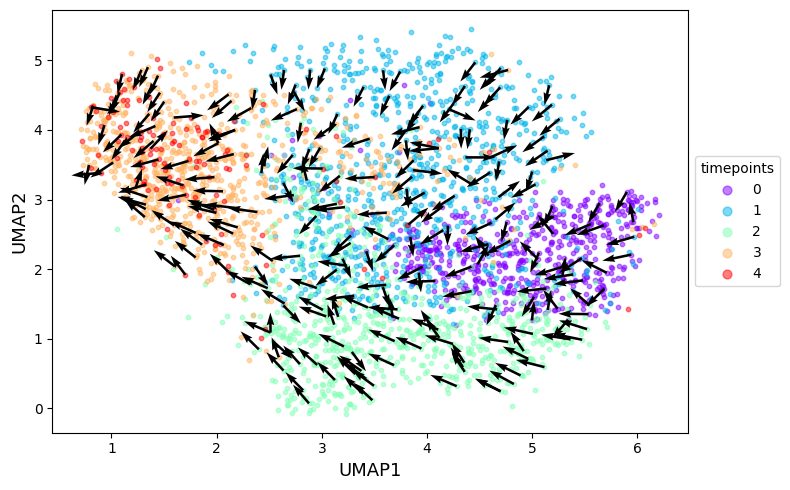

In [28]:
c_l = all_true_umap_df["time"].to_list()
xg = 10
yg = 20
xgrid = np.linspace(int(all_true_umap[:,0].min()), int(all_true_umap[:,0].max()), xg)
ygrid = np.linspace(int(all_true_umap[:,1].min()), int(all_true_umap[:,1].max()), yg)

fig, ax = plt.subplots(figsize = (8,5))
for n,g in all_true_umap_df.groupby("time"):
    ax.scatter(g[0].values, g[1].values, s = 10, label=n, c=color_dict[n], alpha=0.5)#'gray')
plt.legend(markerscale=2, loc='center left', bbox_to_anchor=(1, 0.5), title="timepoints")


for xi in range(xg-1): 
    for yi in range(yg-1): 
        
        xmin, xmax = xgrid[xi], xgrid[xi+1]
        ymin, ymax = ygrid[yi], ygrid[yi+1]
    
        in_x = (all_true_umap[:,0] > xmin) & (all_true_umap[:,0] < xmax)
        in_y = (all_true_umap[:,1] > ymin) & (all_true_umap[:,1] < ymax)
        in_box = in_x & in_y    
        
        if in_box.sum() > 3: 
            ix = np.random.choice(np.where(in_box)[0],2)# max(3, int(in_box.sum() * 0.002)))

            xv = train_val_latent.iloc[:,:-1].values[ix,:]
            xv_t = train_val_latent.iloc[:,-1].values[ix]

            xv_t = np.array([train_dataset.cells_time(xv_t_i) for xv_t_i in xv_t])
            curr_score_t=[]
            for xv_t_i, xv_i in zip(xv_t,xv):
                curr_score_t.append(score["forward"](random.PRNGKey(0), xv_t_i,xv_i.reshape(1,vae_latent_dim))/ts.sde.g(xv_t_i,xv_i))
            curr_score = np.vstack(curr_score_t)

            xv = xv + curr_score

            t_emb = get_timestep_embedding( train_val_latent.iloc[:,-1].values[ix], vae_t_dim)
            pred_traj_t = jnp.concatenate((xv,t_emb),-1)

            xv = dec.apply(dec_init_params, None, pred_traj_t)

            xv = mapper.transform(xv) - all_true_umap[ix,:]
            xv = xv / np.linalg.norm(xv, axis = 1)[:,np.newaxis]

            ax.quiver(all_true_umap[ix,0], all_true_umap[ix,1], xv[:,0], xv[:,1], scale =3.5, scale_units = 'xy', 
                width = .004)
ax.set_xlabel('UMAP1', fontdict={"size":13})
ax.set_ylabel('UMAP2', fontdict={"size":13})
plt.tight_layout()
# plt.savefig(f"{SAVE_PATH}/cell_drift_original_space.png", dpi=300)
plt.show()

5. Identify drift-genes

In [29]:
dec = hk.transform(lambda z: Decoder(output_shape=vae_input_dim, hidden_size=vae_dec_hidden_dim)(z))
rng_seq = hk.PRNGSequence(1)
dec_init_params = dec.init(next(rng_seq), z=np.zeros((val_data.shape[0], vae_latent_dim+vae_t_dim)))

for key in tr_model.vae_params.keys():
    if "dec" in key:
        dec_init_params[key.split("~/")[1]] = tr_model.vae_params[key]
        
def decoder_output(z):
    
    recon_data = dec.apply(dec_init_params, None, z)
    return recon_data

params = tr.training_setup.state[1]
score = broadcast(lambda model, params: partial(tr.training_setup.score(model), params), tr.training_setup.model, params)

top_n=20
drift_genes = {}
shuffled_drift_genes={}

for int_t in pred_trajectories_w_time["time"].unique():

    print ("time:", int_t)
    shuffled_drift_genes[int_t] = []

    z_traj = pred_trajectories_w_time[pred_trajectories_w_time["time"]==int_t].values[:,:-1]
    t_emb = get_timestep_embedding(pred_trajectories_w_time[pred_trajectories_w_time["time"]==int_t].values[:,-1], 8)
    pred_traj_t = jnp.concatenate((z_traj,t_emb),-1)
    z_score = score["forward"](random.PRNGKey(0), train_dataset.cells_time(int_t), z_traj)
    z_score_t = jnp.concatenate((z_score, t_emb), -1)

    #print ("computing jacobian-vector product (jvp)")
    output, jvp = jax.jvp(decoder_output, (pred_traj_t,), (z_score_t,))
    jvp_df = pd.DataFrame(jvp, columns=train_data.columns[:-1])

    # create null distribution by shuffling cells in latent space
    for i in range(100):
        z_traj_shuffled = jax.random.permutation(random.PRNGKey(i), z_traj)
        z_score_shuffled = score["forward"](random.PRNGKey(0), train_dataset.cells_time(int_t), z_traj_shuffled)
        z_score_shuffled_t = jnp.concatenate((z_score_shuffled, t_emb), -1)
        output_shuffled, jvp_shuffled = jax.jvp(decoder_output, (pred_traj_t,), (z_score_shuffled_t,))
        jvp_shuffled_df = pd.DataFrame(jvp_shuffled, columns=train_data.columns[:-1])
        shuffled_drift_genes[int_t].append(jvp_shuffled_df.mean().to_frame().T) 

    #print ("identifying drift positive & negative genes")
    score_pos_genes = jvp_df.mean().sort_values(ascending=False)[:]
    score_neg_genes = jvp_df.mean().sort_values(ascending=False)[::-1]

    print ("#positive drift genes:",sum(jvp_df.mean().sort_values(ascending=False)>0))

    drift_genes[int_t] = {"pos": score_pos_genes, "neg": score_neg_genes}

# with open(f"{SAVE_PATH}/drift_genes.pkl","wb") as f:
#         pickle.dump(drift_genes,f,protocol=pickle.HIGHEST_PROTOCOL)

time: 0
#positive drift genes: 823
time: 1
#positive drift genes: 901
time: 2
#positive drift genes: 1077
time: 3
#positive drift genes: 1084
time: 4
#positive drift genes: 1114


In [13]:
with open(f"{SAVE_PATH}/drift_genes.pkl","wb") as f:
        pickle.dump(drift_genes,f,protocol=pickle.HIGHEST_PROTOCOL)

In [30]:
from scipy.stats import ttest_ind

for curr_tp in range(5):
    # curr_tp = 1
    print ("time:", curr_tp)
    drift_genes_t = drift_genes[curr_tp]['pos']

    drift_gene_pval = []
    for gene in drift_genes_t.index:
        if drift_genes_t[gene]<0:
            continue
        gene_null_distribution=[]
        for i in range(100):
            gene_null_distribution.extend(shuffled_drift_genes[curr_tp][i][gene].to_list())
        p = ttest_ind([drift_genes_t[gene]], gene_null_distribution, alternative="two-sided",).pvalue
        drift_gene_pval.append([gene,p])
    
    drift_gene_pval_df = pd.DataFrame(drift_gene_pval, columns=["gene","pval"])
    # drift_gene_pval_df.to_csv(f"{SAVE_PATH}/drift_genes_ttest_significance_testing_tp{curr_tp}.csv")

    print (drift_gene_pval_df[drift_gene_pval_df["gene"].isin(drift_genes[curr_tp]['pos'].index[:20].tolist())])

time: 0
       gene          pval
0      AREG  1.755191e-47
1       FTL  1.573739e-37
2     HMGA1  5.791907e-18
3   CCDC85B  1.623414e-66
4      CA12  9.383490e-02
5   PLA2G16  7.393923e-20
6     AVPI1  1.355179e-55
7      GPX2  1.869339e-53
8   B4GALT4  1.313828e-45
9    IGFBP6  1.360952e-07
10   S100A6  1.559362e-08
11  ALDH3A1  9.276196e-64
12   MT-ND2  1.445920e-71
13   S100A3  1.925014e-27
14   OSGIN1  3.275041e-35
15  AKR1B10  3.224799e-71
16     MALL  3.091139e-32
17    COTL1  4.841777e-05
18     FJX1  1.049930e-21
19    DUSP4  2.307248e-62
time: 1
         gene          pval
0     ANGPTL4  6.476082e-35
1      PMEPA1  4.514675e-29
2        ULK1  3.507869e-02
3        JUNB  3.858583e-34
4       FSTL3  1.881658e-06
5   TNFRSF12A  1.200348e-31
6     GADD45B  1.574142e-37
7        FHL2  2.948627e-31
8    SERPINE1  8.293346e-44
9       PRRX2  2.186199e-45
10    TSPAN15  1.103863e-01
11       TNS4  2.198638e-22
12    BLOC1S2  3.222309e-04
13      CMTM3  2.226297e-29
14     TRIM47  8.3

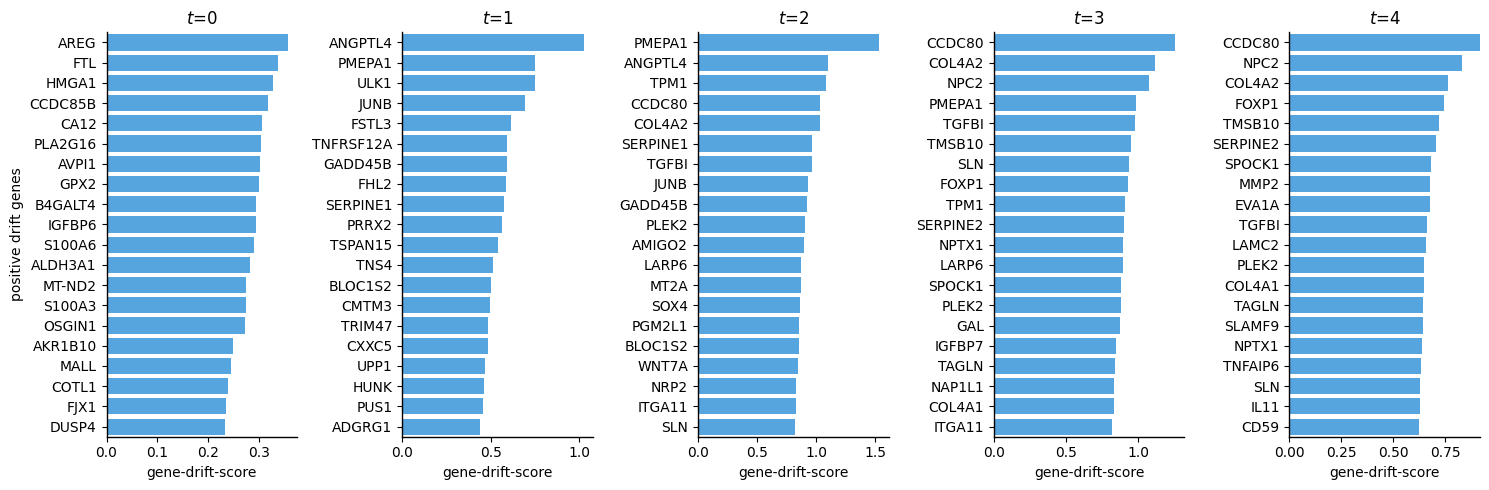

In [31]:
fig, axs = plt.subplots(1,5, figsize=(15, 5))
fig.subplots_adjust(hspace = .5, wspace=.001)

axs = axs.ravel()
i=0
for (k,v) in drift_genes.items():
    pos_drift_scores = v['pos'].to_frame()[:top_n]
    stage=timepoint_map[k]

    plt.margins(0, 0)
    axs[i].set_title(r'$t$'+f'={k}')
    pos_drift_scores["gene"] = pos_drift_scores.index
    pos_drift_scores.columns=["value","gene"]
    sns.barplot(data=pos_drift_scores, y="gene",x="value", orient="h", ax=axs[i], color="#3fa9f5")# palette="PuBu_r")
    axs[i].set_ylabel('')
    if i ==0 or i==6:
        axs[i].set_ylabel('positive drift genes')
    axs[i].set_xlabel('gene-drift-score')

    for spine in ['top', 'right', 'bottom', 'left']:
        axs[i].spines[spine].set_linewidth(1)
    axs[i].spines[['right', 'top']].set_visible(False)
    i+=1

plt.tight_layout()
# plt.savefig(f"{SAVE_PATH}/positive_drift_genes.png.png",dpi=300)
plt.show()

6. Perturbation analysis

In [365]:
def get_drift_results(train_data, val_data, ts, tr_model, drift_tp):
    train_recon, train_latent, val_recon, val_latent = get_model_latents(train_data, val_data, ts, tr_model)
    pred_trajectories, pred_trajectories_alive, timepoints, timepoints_alive, statuses = get_latent_trajectories(train_dataset,train_latent, tps, tr_model, ts, t_0_orig=drift_tp, max_size=2000)
    # for held-out timepoints
    pred_trajectories_alive_w_time = pd.DataFrame(pred_trajectories_alive)
    pred_trajectories_alive_w_time["time"] = timepoints_alive
    test_trajs = get_test_trajs(pred_trajectories_alive_w_time, val_data["time"].to_list())

    pred_trajectories_w_time = pd.DataFrame(pred_trajectories)
    pred_trajectories_w_time["time"] = timepoints
    test_trajs_all = get_test_trajs(pred_trajectories_w_time, val_data["time"].to_list())

    recon_data = get_reconstructed_trajectory(pred_trajectories_alive, val_data, vae_input_dim, vae_dec_hidden_dim,vae_latent_dim, tr_model, timepoints_alive)

    return train_latent, val_latent, pred_trajectories_alive_w_time, recon_data, statuses, timepoints_alive

def knn_classifier(X,y,X_test,n_neigh=1):
    neigh = KNeighborsClassifier(n_neighbors=n_neigh)
    neigh.fit(X, y)
    y_pred = neigh.predict(X_test)
    return y_pred

def mlp_classifier(X,y,X_test, hidden_layer_sizes=(64)):
    mlp = MLPClassifier(random_state=1, max_iter=300, hidden_layer_sizes=hidden_layer_sizes,
                          learning_rate_init=0.0001, learning_rate='constant')
    mlp.fit(X, y)
    y_pred = mlp.predict(X_test)
    return y_pred

In [336]:
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.neural_network import MLPClassifier
# from sklearn.neighbors import KNeighborsClassifier
from collections import Counter

X_df=pd.concat([train_latent, val_latent])

X = X_df.values[:,:-1]
y = X_df.values[:,-1]
X_train, X_test, y_train, y_test = train_test_split(X, y , random_state=104,test_size=0.2, shuffle=True)


# KNN CV
# parameters = {'n_neighbors':np.arange(10)}
# svc =  KNeighborsClassifier(n_neighbors=10)
# clf = GridSearchCV(svc, parameters)
# clf.fit(X, y)
# print ("knn:", clf.best_params_, clf.best_score_)

# MLP CV
parameters = {"hidden_layer_sizes": [(64,), (64,64)], #(50,50), (50,), (50,100,50), (100,)],
              'learning_rate_init': [0.001, 0.0001],
              'learning_rate': ["constant", "invscaling", "adaptive"],}
mlp = MLPClassifier(random_state=1, max_iter=300)
clf = GridSearchCV(mlp, parameters)
clf.fit(X, y)
print ("mlp:", clf.best_params_, clf.best_score_)

knn: {'n_neighbors': 9} 0.7331621240146546


In [366]:
drift_tp=2 # timepoint at which perturbation is introduced
random_genes=False
n_neigh=1
knn=False
mlp=True
hidden_layer_sizes=(64,64)

6.1 Run 10 trials of unperturbed vs perturbed trajectories

In [367]:
perturbed = {}
unperturbed = {}
n_trials = 10
for perturb_val in [-25,-20, -15,-10,0,10, 15,20,25]:
    for drift_genes_subset in ['TPM1','AMIGO2']:

        perturbed[f"{drift_genes_subset}_{perturb_val}"] = pd.DataFrame()
        unperturbed[f"{drift_genes_subset}_{perturb_val}"] = pd.DataFrame()

        for tr_i in range(n_trials):
            
            train_data_w_drift_gene = train_data.copy()
            val_data_w_drift_gene = val_data.copy()

            percent_cells_to_drift = 1

            if drift_tp in train_tps:
                cells_at_tp=train_data_w_drift_gene[train_data_w_drift_gene["time"]==drift_tp]
            else:
                cells_at_tp=val_data_w_drift_gene[val_data_w_drift_gene["time"]==drift_tp]

            cells_at_tp_rand = np.random.choice(cells_at_tp.shape[0], int(cells_at_tp.shape[0]*percent_cells_to_drift), replace=False)

            cells_at_tp_for_drift = cells_at_tp.index[cells_at_tp_rand]
            
            
            if drift_tp in train_tps:
                train_data_w_drift_gene.loc[cells_at_tp_for_drift,drift_genes_subset] = perturb_val
            else:                                                                   
                val_data_w_drift_gene.loc[cells_at_tp_for_drift,drift_genes_subset] = perturb_val
            

            if drift_tp in train_tps:
                train_latent_w_drift_gene, val_latent_w_drift_gene, pred_trajectories_alive_w_time_w_drift_gene, recon_data_w_drift_gene, statuses_w_drift_gene, timepoints_alive_w_drift_gene = get_drift_results(train_data_w_drift_gene, val_data_w_drift_gene, ts, tr_model, drift_tp)
                train_latent_w_time, val_latent_w_time, pred_trajectories_alive_w_time, recon_data, statuses, timepoints_alive = get_drift_results(train_data, val_data, ts, tr_model, drift_tp)
            else:
                train_latent_w_drift_gene, val_latent_w_drift_gene, pred_trajectories_alive_w_time_w_drift_gene, recon_data_w_drift_gene, statuses_w_drift_gene, timepoints_alive_w_drift_gene = get_drift_results(val_data_w_drift_gene, val_data_w_drift_gene, ts, tr_model, drift_tp)
                train_latent_w_time, val_latent_w_time, pred_trajectories_alive_w_time, recon_data, statuses, timepoints_alive = get_drift_results(val_data, val_data, ts, tr_model, drift_tp)

                #print (top_n_drift_genes, pred_trajectories_alive_w_time_w_drift_gene['time'].value_counts())

            X_test = pred_trajectories_alive_w_time_w_drift_gene.values[:,:-1]
            y_test = pred_trajectories_alive_w_time_w_drift_gene.values[:,-1]

            X_test_orig = pred_trajectories_alive_w_time.values[:,:-1]
            y_test_orig = pred_trajectories_alive_w_time.values[:,-1]

            X_test_orig = recon_data
            y_test_orig = timepoints_alive

            if knn:
                y_pred_w_drift = knn_classifier(X,y,X_test, n_neigh=n_neigh)
                y_pred_orig = knn_classifier(X,y,X_test_orig,  n_neigh=n_neigh)
            elif mlp:
                y_pred_w_drift = mlp_classifier(X,y,X_test, hidden_layer_sizes)
                y_pred_orig = mlp_classifier(X,y,X_test_orig,  hidden_layer_sizes)
                
            y_pred_dict = Counter(y_pred_w_drift)
            y_pred_orig_dict = Counter(y_pred_orig)
 
            perturbed[f"{drift_genes_subset}_{perturb_val}"] = pd.concat([perturbed[f"{drift_genes_subset}_{perturb_val}"], pd.DataFrame.from_dict(y_pred_dict, orient='index' ).T])
            
            unperturbed[f"{drift_genes_subset}_{perturb_val}"] = pd.concat([unperturbed[f"{drift_genes_subset}_{perturb_val}"], pd.DataFrame.from_dict(y_pred_orig_dict, orient='index' ).T])
            

6.2 Run 10 trials of random vs unperturbed trajectories

In [32]:
perturbed_random = {}
unperturbed_random = {}
perturbed_random_increase = {}

# select a subset of random genes, that not part of positive drift genes at "drift_tp", to introduce perturbations
drift_genes_subset = drift_genes[drift_tp]['pos'][drift_genes[drift_tp]['pos']>0].index.to_list()[:50]
drift_genes_random_subset = df.loc[:,~df.columns.isin(drift_genes_subset+['time'])].columns.to_list()
drift_genes_random_subset = np.random.choice(drift_genes_random_subset, size=10, replace=False)

for perturb_val in [-25,-20, -15,-10,0,10, 15,20,25]:
    perturbed_random[f"{perturb_val}"] = pd.DataFrame()
    unperturbed_random[f"{perturb_val}"] = pd.DataFrame()

    for i in range(10):

        drift_genes_subset = drift_genes_random_subset[i]

        train_data_w_drift_gene = train_data.copy()
        val_data_w_drift_gene = val_data.copy()

        percent_cells_to_drift = 1

        if drift_tp in train_tps:
            cells_at_tp=train_data_w_drift_gene[train_data_w_drift_gene["time"]==drift_tp]
        else:
            cells_at_tp=val_data_w_drift_gene[val_data_w_drift_gene["time"]==drift_tp]

        cells_at_tp_rand = np.random.choice(cells_at_tp.shape[0], int(cells_at_tp.shape[0]*percent_cells_to_drift), replace=False)

        cells_at_tp_for_drift = cells_at_tp.index[cells_at_tp_rand]
        
        
        if drift_tp in train_tps:
            train_data_w_drift_gene.loc[cells_at_tp_for_drift,drift_genes_subset] = perturb_val
        else:                                                                   
            val_data_w_drift_gene.loc[cells_at_tp_for_drift,drift_genes_subset] = perturb_val
        
        if drift_tp in train_tps:
            train_latent_w_drift_gene, val_latent_w_drift_gene, pred_trajectories_alive_w_time_w_drift_gene, recon_data_w_drift_gene, statuses_w_drift_gene, timepoints_alive_w_drift_gene = get_drift_results(train_data_w_drift_gene, val_data_w_drift_gene, ts, tr_model, drift_tp)
            train_latent_w_time, val_latent_w_time, pred_trajectories_alive_w_time, recon_data, statuses, timepoints_alive = get_drift_results(train_data, val_data, ts, tr_model, drift_tp)
        else:
            train_latent_w_drift_gene, val_latent_w_drift_gene, pred_trajectories_alive_w_time_w_drift_gene, recon_data_w_drift_gene, statuses_w_drift_gene, timepoints_alive_w_drift_gene = get_drift_results(val_data_w_drift_gene, val_data_w_drift_gene, ts, tr_model, drift_tp)
            train_latent_w_time, val_latent_w_time, pred_trajectories_alive_w_time, recon_data, statuses, timepoints_alive = get_drift_results(val_data, val_data, ts, tr_model, drift_tp)

            #print (top_n_drift_genes, pred_trajectories_alive_w_time_w_drift_gene['time'].value_counts())

        X_test = pred_trajectories_alive_w_time_w_drift_gene.values[:,:-1]
        y_test = pred_trajectories_alive_w_time_w_drift_gene.values[:,-1]

        X_test_orig = pred_trajectories_alive_w_time.values[:,:-1]
        y_test_orig = pred_trajectories_alive_w_time.values[:,-1]

        if knn:
            y_pred_w_drift = knn_classifier(X,y,X_test, n_neigh=n_neigh)
            y_pred_orig = knn_classifier(X,y,X_test_orig,  n_neigh=n_neigh)
        elif mlp:
            y_pred_w_drift = mlp_classifier(X,y,X_test, hidden_layer_sizes)
            y_pred_orig = mlp_classifier(X,y,X_test_orig,  hidden_layer_sizes)
            
        y_pred_dict = Counter(y_pred_w_drift)
        y_pred_orig_dict = Counter(y_pred_orig)


        perturbed_random[f"{perturb_val}"] = pd.concat([perturbed_random[f"{perturb_val}"],pd.DataFrame.from_dict(y_pred_dict, orient='index' ).T])
        unperturbed_random[f"{perturb_val}"] = pd.concat([perturbed_random[f"{perturb_val}"],pd.DataFrame.from_dict(y_pred_orig_dict, orient='index' ).T])

perturbed_random["random_genes"] = drift_genes_random_subset
perturbed_random_increase["random_genes"] = drift_genes_random_subset

In [370]:
with open("{SAVE_PATH}/perturbed_top20_positive_drift_tp3.pkl","wb") as f:
        pickle.dump(perturbed,f,protocol=pickle.HIGHEST_PROTOCOL)

with open("{SAVE_PATH}/unperturbed_top20_positive_drift_tp3.pkl","wb") as f:
        pickle.dump(unperturbed,f,protocol=pickle.HIGHEST_PROTOCOL)

# with open("{SAVE_PATH}/perturbed_random_10genes.pkl","wb") as f:
#         pickle.dump(perturbed_random,f,protocol=pickle.HIGHEST_PROTOCOL)

# with open("{SAVE_PATH}/unperturbed_random_10genes.pkl","wb") as f:
#         pickle.dump(unperturbed_random,f,protocol=pickle.HIGHEST_PROTOCOL)

perturbed vs unperturbed

In [18]:
import scipy

perturb_vs_unperturb_pval = {}

for k in perturbed:
    gene, pert_val = k.split("_")

    if not gene in perturb_vs_unperturb_pval:
        perturb_vs_unperturb_pval[k] = []

    perturb_vs_unperturb_pval[k].append([])

    for _t in timepoints_sorted:
        if _t not in unperturbed[k].columns:
            unperturbed[k][_t] = 0
        if _t not in perturbed[k].columns:
            perturbed[k][_t] = 0
        gene_p = scipy.stats.ttest_ind(perturbed[k][_t], unperturbed[k][_t],alternative='greater')
        perturb_vs_unperturb_pval[k][-1].append(gene_p.pvalue)

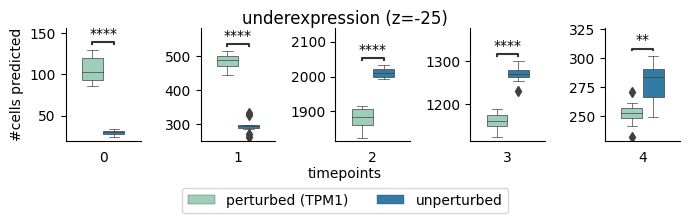

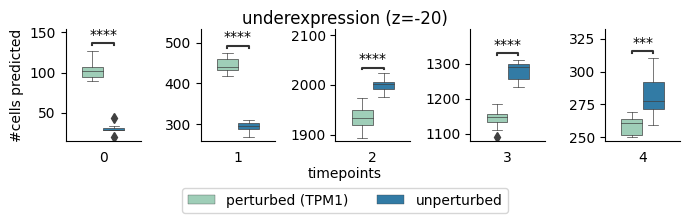

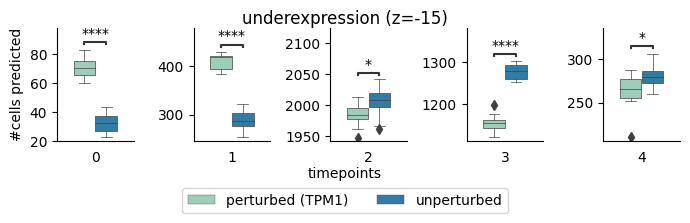

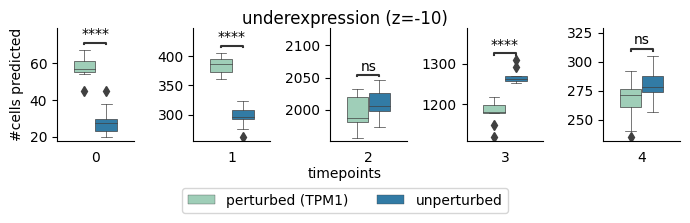

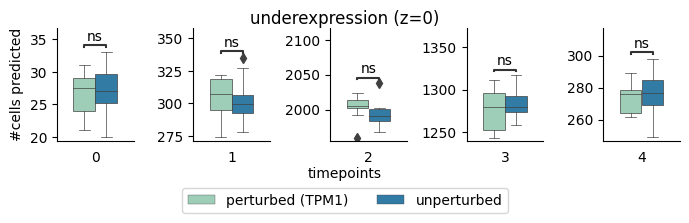

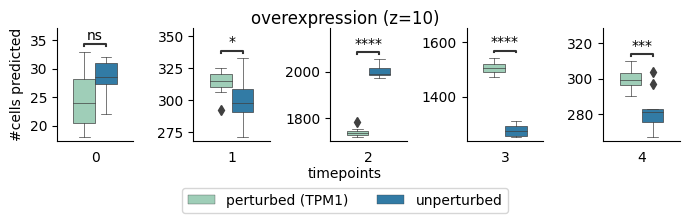

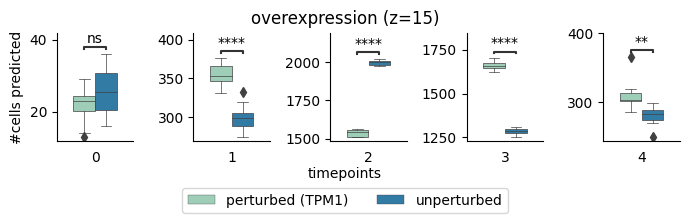

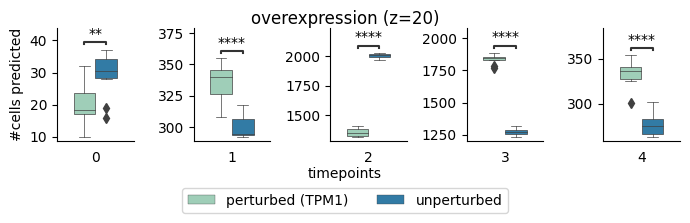

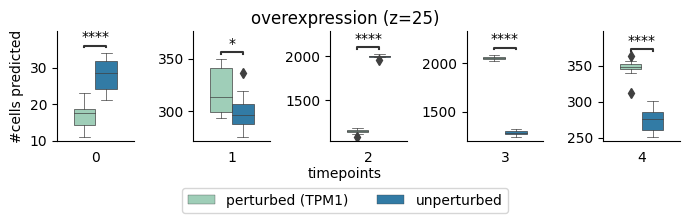

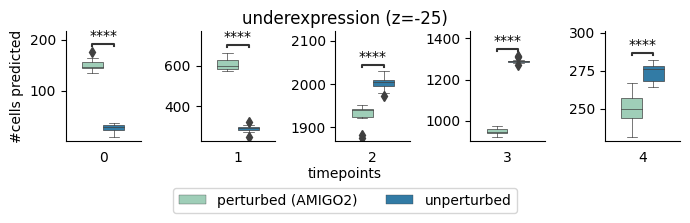

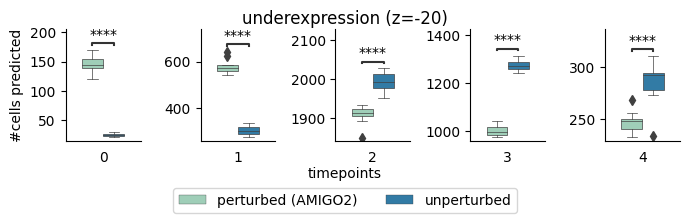

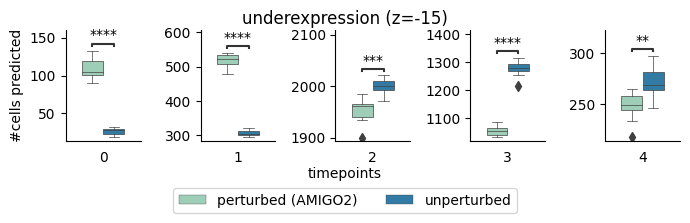

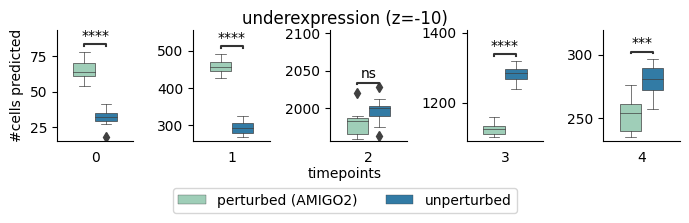

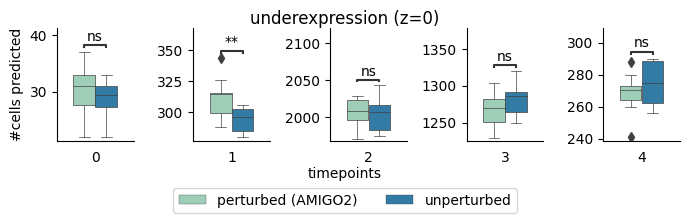

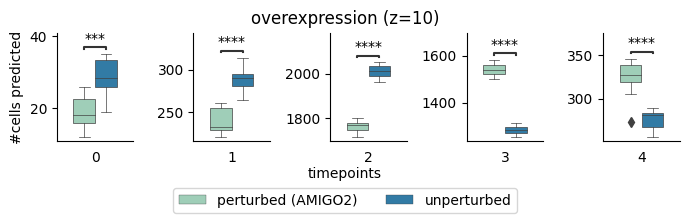

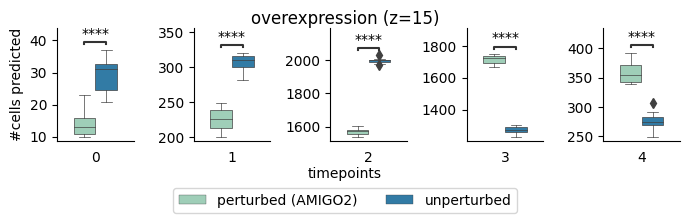

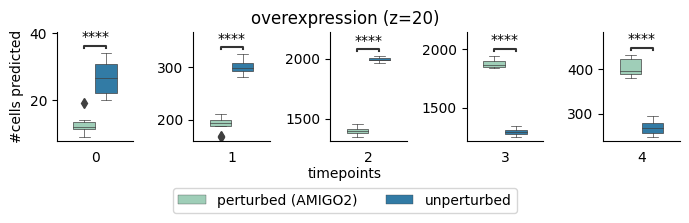

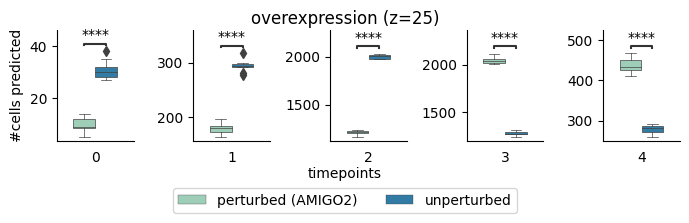

In [20]:
for gene_name in ["TPM1","AMIGO2"]:
    for plot_pert_val in ['-25','-20','-15','-10','0','10','15','20','25']:
        all_pert_vs_unpert_inc = []
        pert_type=[]

        idxs = []
        for k,v in perturb_vs_unperturb_pval.items():
            if gene_name in k:
                _, pert_val = k.split("_")
                if pert_val==plot_pert_val:
                    all_pert_vs_unpert_inc.extend(perturbed[k][[0.0, 1.0, 2.0, 3.0, 4.0]].values)
                    all_pert_vs_unpert_inc.extend(unperturbed[k][[0.0, 1.0, 2.0, 3.0, 4.0]].values)

                    idxs.extend([pert_val]*2*len(perturbed[k].values))

                    pert_type.extend([f"perturbed ({gene_name})"]*len(perturbed[k].values))
                    pert_type.extend(["unperturbed"]*len(unperturbed[k].values))
        
        all_pert_vs_unpert_inc_df = pd.DataFrame(all_pert_vs_unpert_inc)
        all_pert_vs_unpert_inc_df["type"] = pert_type
        all_pert_vs_unpert_inc_df["pert"] = idxs
        fig, axes = plt.subplots(1,5, figsize = (7,2))

        subcat_palette = sns.dark_palette("#8BF", reverse=True, n_colors=2)
        states_palette = sns.color_palette("YlGnBu", n_colors=2)

        all_pert_vs_unpert_inc_df_melt = all_pert_vs_unpert_inc_df.melt(['pert','type'])
        for i in range(5):
            subgroup = all_pert_vs_unpert_inc_df_melt[all_pert_vs_unpert_inc_df_melt["variable"]==i]
            box_pairs=[((i,f"perturbed ({gene_name})"),(i,"unperturbed")),]

            sns.boxplot(ax=axes[i],data=subgroup,x="variable", y='value', hue='type',palette=states_palette,linewidth=0.5,color="black",)
            test_results = add_stat_annotation(ax=axes[i],data=subgroup,x="variable", y='value', hue='type', 
                                                    box_pairs=box_pairs,
                                                    test='t-test_ind',#'Mann-Whitney', 
                                                    text_format='star',
                                                    loc='inside', verbose=0)
            # if i!=4:
            axes[i].get_legend().remove()
            axes[i].set_ylabel('')
            axes[i].set_xlabel('')
            axes[i].tick_params(bottom=False, left=True)
            axes[i].spines['top'].set_visible(False)
            axes[i].spines['right'].set_visible(False)

        axes[0].set_ylabel("#cells predicted")
        fig.text(0.5, 0.01, 'timepoints', ha='center',)
        handles, labels = axes[-1].get_legend_handles_labels()
        fig.legend(handles, labels, loc='lower center',ncol=2, bbox_to_anchor=(0.5, -0.2))
        
        plt.subplots_adjust(wspace=0.1, hspace=1)
        if int(plot_pert_val)<0:
            pert_level="underexpression"
        elif int(plot_pert_val)>0:
            pert_level="overexpression"
        fig.suptitle( f"{pert_level} (z={plot_pert_val})",x=0.5, y=0.85, fontsize=12)
        plt.tight_layout()
        # plt.savefig(f"{SAVE_PATH}/{gene_name}_{pert_level}_{plot_pert_val}.png",
        #              dpi=300, bbox_inches="tight")
        plt.show()

7. Get dead-live genes and differentially expressed genes between dead-live cells

In [21]:
def get_estimated_death_at_t(t, x_t, x_t_plus_1, status):
    params = tr.training_setup.state[1][FERRYMAN]
    eval_ferryman = partial(tr.training_setup.ferryman.apply, params=params, direction="forward")
    death_threshold = ts.sde.killer(t/train_dataset.steps_num, x_t)
    key, death_threshold = ts.sde.reweight_killing(random.PRNGKey(0), FORWARD, death_threshold, eval_ferryman, x_t, status, t/train_dataset.steps_num, x_t_plus_1)
    return death_threshold                     

def get_dead_cells(t, trajs, statuses, birth_statuses):

    dead_cells = []

    status_t = statuses[t]
    status_t_plus_1 = statuses[t+1]
    birth_status_t_plus_1 = birth_statuses[t+1]

    estimated_death_threshold = get_estimated_death_at_t(t, trajs[t], trajs[t+1], status_t)

    estimated_death_threshold_dead_cells=[]

    alive_t_idx = np.where(status_t)[0]
    dead_t_plus_1_idx= [] 
    for idx in alive_t_idx:
        if status_t[idx] & ~status_t_plus_1[idx]:
            dead_cells.append(trajs[t][idx])
            dead_t_plus_1_idx.append(idx)
            estimated_death_threshold_dead_cells.append(estimated_death_threshold[idx].item())
        elif birth_status_t_plus_1[idx].item() != 0:
            dead_cells.append(trajs[t][idx])
            dead_t_plus_1_idx.append(idx)
            estimated_death_threshold_dead_cells.append(estimated_death_threshold[idx].item())

    return dead_cells, estimated_death_threshold, estimated_death_threshold_dead_cells, dead_t_plus_1_idx

def get_split_cells(t, statuses, birth_statuses):

    split_cells=[]

    status_t = statuses[t]
    birth_status_t_plus_1 = birth_statuses[t+1]

    alive_t_idx = np.where(status_t)[0]

    for idx in alive_t_idx:
        birth_idx_t_plus_1 = np.where(birth_status_t_plus_1==idx)[0]
        if len(birth_idx_t_plus_1)==0:
            continue
        else:
            if idx == birth_idx_t_plus_1[0]:
                continue
            split_cells.append((idx, (idx,birth_idx_t_plus_1[0])))
    return split_cells

def get_reborn_cells(t, trajs, statuses, birth_statuses):

    reborn_cells=[]

    status_t = statuses[t]
    status_t_plus_1 = statuses[t+1]
    birth_status_t_plus_1 = birth_statuses[t+1]
    trajs_t_plus_1 = trajs[t+1]

    dead_to_alive = np.logical_and(~status_t, status_t_plus_1)

    dead_to_alive_t_plus_1_idx = np.where(dead_to_alive)[0]

    for idx in dead_to_alive_t_plus_1_idx:
        if birth_status_t_plus_1[idx]==0:
            reborn_cells.append(trajs_t_plus_1[idx])
    
    return reborn_cells

def cell_time_to_real_time(t):
    times_orig = train_dataset.times_orig
    t_real = (t*(times_orig[-1]-times_orig[0]))/train_dataset.steps_num + times_orig[0]
    return t_real

def get_reconstructed_dead_cells(pred_trajectories, val_data, vae_input_dim, vae_dec_hidden_dim, tr_model, timepoints):
    dec = hk.transform(lambda z: Decoder(output_shape=vae_input_dim, hidden_size=vae_dec_hidden_dim)(z))
    rng_seq = hk.PRNGSequence(1)
    dec_init_params = dec.init(next(rng_seq), z=np.zeros((val_data.shape[0], vae_latent_dim+vae_t_dim)))

    for key in tr_model.vae_params.keys():
        if "dec" in key:
            dec_init_params[key.split("~/")[1]] = tr_model.vae_params[key]
            
    t_emb = get_timestep_embedding(timepoints, vae_t_dim)
    pred_traj_t = jnp.concatenate((pred_trajectories,t_emb),-1)

    recon_data = dec.apply(dec_init_params, None, pred_traj_t)
    recon_data.shape

    return recon_data

In [22]:
params = tr.training_setup.state[1]
eval_score = broadcast(lambda model, params: partial(tr.training_setup.score(model), params), tr.training_setup.model, params)
params_ferryman = tr_model.training_setup.state[1][FERRYMAN]
eval_ferryman= partial(tr_model.training_setup.ferryman.apply, params=params_ferryman, direction=FORWARD)

train_val_latent = pd.concat([train_latent, val_latent])
val_data_init = train_val_latent[train_val_latent["time"]==timepoints_sorted[0]].iloc[:,:-1].values

max_size=2000

if max_size!=0:
    val_data_init = sample(val_data_init, size = (max_size, ))

print (val_data_init.shape)
trajs, _, statuses, birth_statuses = ts.sde.sample_trajectory(random.PRNGKey(0), FORWARD, val_data_init, eval_score, 
                                                                eval_ferryman, corrector="",  test=False, max_size=max_size)

(2000, 50)


In [23]:
cell_real_time_ordered=True

dead_cell_count = []
dead_cells_per_interval={}
interval_count=0
all_times = list(map(lambda t: int(train_dataset.cells_time(t)*train_dataset.steps_num), timepoints_sorted))

# Get dead cells in each in/media/sayali/External Dr/Sayali/UDSB/src_vae_fbsde/resultsv1.2/params/zebrafishterval defined by measured timepoints
print ("getting dead cells")
for t in tqdm(np.arange(0,train_dataset.steps_num)):#train_dataset.times:

    start_int = all_times[interval_count]
    end_int = all_times[interval_count+1]

    if t==0:
        interval_i=[]
    
    dead_cells, _, _, _ = get_dead_cells(t, trajs, statuses, birth_statuses)
    if len(dead_cells)!=0:
        dead_cells = np.stack(dead_cells)
        dead_cell_count.append(dead_cells.shape[0])

        if not cell_real_time_ordered:
            dead_cell_time = np.round(cell_time_to_real_time(np.array([t]*dead_cells.shape[0])))
        else:
            dead_cell_time = np.array([t]*dead_cells.shape[0])
            
        recon_dead_cells = get_reconstructed_dead_cells(dead_cells, val_data, vae_input_dim, vae_dec_hidden_dim, tr_model, dead_cell_time)      
        interval_i.extend(recon_dead_cells)

    if t+1 == end_int or t==train_dataset.steps_num:
        dead_cells_per_interval[f"{start_int}_{end_int}"] = interval_i
        interval_i=[]
        interval_count+=1

alive_cells_per_interval={}
interval_count=0
all_times = list(map(lambda t: int(train_dataset.cells_time(t)*train_dataset.steps_num), timepoints_sorted))

# Get live cells in each interval defined by measured timepoints
print ("getting live cells")
for t in tqdm(np.arange(0,train_dataset.steps_num+1)):

    start_int = all_times[interval_count]
    end_int = all_times[interval_count+1]

    if t==0:
        interval_i=[]

    alive_cells = trajs[t][statuses[t]]

    if not cell_real_time_ordered:
        alive_cell_time = np.round(cell_time_to_real_time(np.array([t]*alive_cells.shape[0])))
    else:
        alive_cell_time = np.array([t]*alive_cells.shape[0])

    recon_alive_cells = get_reconstructed_dead_cells(alive_cells, val_data, vae_input_dim, vae_dec_hidden_dim, tr_model, alive_cell_time)        
    interval_i.extend(recon_alive_cells)

    if t == end_int or t==train_dataset.steps_num:
        alive_cells_per_interval[f"{start_int}_{end_int}"] = interval_i
        interval_i=[]
        interval_count+=1

getting dead cells


  0%|          | 0/100 [00:00<?, ?it/s]

getting live cells


  0%|          | 0/101 [00:00<?, ?it/s]

In [24]:
for k,v in dead_cells_per_interval.items():
    print (k, len(v))

0_25 0
25_50 4
50_75 3
75_100 44


In [25]:
for k,v in alive_cells_per_interval.items():
    print (k, len(v))

0_25 33914
25_50 32740
50_75 32665
75_100 32378


In [26]:
gene_list = df.columns.to_list()[:-1]

In [27]:
# Load GOBP genes associated with cell cycle and cell apoptosis
# can be downloaded from https://www.gsea-msigdb.org/gsea/msigdb/human/genesets.jsp 
gst = pd.read_csv("{DATA_PATH}/GOBP_CELL_CYCLE.v2024.1.Hs.tsv", sep='\t',index_col=0)
g_sym = gst.loc['GENE_SYMBOLS'].values[0].split(",")
birth_gst_go = [g for g in set(g_sym) if g in df.columns]

gst = pd.read_csv("{DATA_PATH}/GOBP_APOPTOTIC_SIGNALING_PATHWAY.v2024.1.Hs.tsv", sep='\t', index_col = 0)
g_sym = gst.loc['GENE_SYMBOLS'].values[0].split(",")
death_gst_go = [g for g in set(g_sym) if g in df.columns]

birth_gst_go = [g for g in birth_gst_go if g not in death_gst_go]
death_gst_go = [g for g in death_gst_go if g not in birth_gst_go]

len(birth_gst_go), len(death_gst_go)

(199, 107)

In [28]:
from scipy.stats import mannwhitneyu
from statsmodels.stats.multitest import multipletests

def get_de_genes(interval_i_cells, gene_list):
    # code adapted from: https://www.biostars.org/p/9495368/
    pvalues = []
    log_fold_changes = []
    for gene in gene_list:
        data = pd.concat([interval_i_cells[gene], interval_i_cells['status']], axis=1)
        data.columns = ['expression', 'condition']

        condition_1_expression = data.loc[data['condition'] == data['condition'].unique()[0], 'expression']
        condition_2_expression = data.loc[data['condition'] == data['condition'].unique()[1], 'expression']

        p = mannwhitneyu(condition_1_expression, condition_2_expression)[1]
        log_fold_change = np.log2((condition_2_expression.mean() + 1) / (condition_1_expression.mean() + 1))

        pvalues.append(p)
        log_fold_changes.append(log_fold_change)

    # adjust p-values using FDR
    fdr = multipletests(pvalues, method='fdr_bh')[1]

    # combine p-values, adjusted p-values and log fold changes into a DataFrame for easy viewing
    results = pd.DataFrame({
        'gene': gene_list,
        'p_value': pvalues,
        'fdr': fdr,
        'log_fold_change': log_fold_changes
    })
    return results

sample_alive_cells=True
for int_i in ['75_100']:#dead_cells_per_interval.keys():
    if len(dead_cells_per_interval[int_i])==0:
        continue

    interval_i_dead_df= pd.DataFrame(np.stack(dead_cells_per_interval[int_i]), columns=gene_list)
    genes_to_check = interval_i_dead_df.std().sort_values(ascending=False).index[:]
    interval_i_alive_df= pd.DataFrame(np.stack(alive_cells_per_interval[int_i]), columns=gene_list)
        
    if sample_alive_cells and len(interval_i_dead_df)<len(interval_i_alive_df):
        n=len(interval_i_dead_df)#100
        interval_i_alive_df= pd.DataFrame(np.stack(alive_cells_per_interval[int_i]), columns=gene_list).sample(n=n)

    interval_i_cells = pd.concat([interval_i_dead_df,interval_i_alive_df])
    interval_i_cells["status"] = ["dead"]*len(interval_i_dead_df) + ["live"]*len(interval_i_alive_df)

    interval_i_de_genes = get_de_genes(interval_i_cells, gene_list)

    top_de_genes = interval_i_de_genes.sort_values(by=["fdr"])["gene"].to_list()[:40]
    tmp_top_de_genes=interval_i_de_genes.sort_values(by=["fdr"])["gene"].to_list()[:70]
    go_birth_genes= list(set(tmp_top_de_genes).intersection(set(birth_gst_go)))
    go_death_genes = list(set(tmp_top_de_genes).intersection(set(death_gst_go)))

    interval_i_cells_w_de_genes = interval_i_cells[go_birth_genes+go_death_genes+["status"]]
    interval_i_cells_w_de_genes = interval_i_cells_w_de_genes.melt("status")

In [29]:
interval_i_cells_w_de_genes_GO = interval_i_cells_w_de_genes[interval_i_cells_w_de_genes["variable"].isin(["PTTG1","CDKN3",'PMAIP1', 'CD70'])]
interval_i_cells_w_de_genes_GO["GO_status"] = interval_i_cells_w_de_genes_GO["variable"].map({"PTTG1":"GO_alive","CDKN3":"GO_alive",
                                                                                           "PMAIP1":"GO_dead","CD70":"GO_dead"})
interval_i_cells_w_de_genes_GO.head()

,status,variable,value,GO_status
616,dead,CDKN3,-0.417336,GO_alive
617,dead,CDKN3,-0.299624,GO_alive
618,dead,CDKN3,-0.635502,GO_alive
619,dead,CDKN3,-0.193938,GO_alive
620,dead,CDKN3,-1.081373,GO_alive


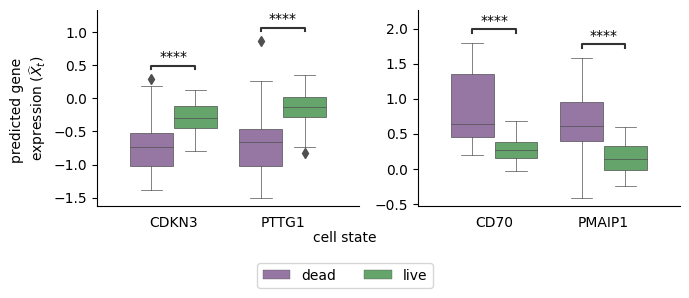

In [30]:
fig, axes = plt.subplots(1,2, figsize = (7,2.5))
subcat_palette = sns.dark_palette("#8BF", reverse=True, n_colors=2)
states_palette = sns.color_palette("PRGn", n_colors=4)
i=0
for n,g in interval_i_cells_w_de_genes_GO.groupby("GO_status"):
    subgroup = g
    box_pairs=[]
    for gene_name in g["variable"].unique():
        box_pairs.append(((f"{gene_name}","dead"),(f"{gene_name}","live")))

    sns.boxplot(ax=axes[i],data=subgroup,x="variable", y='value', hue='status',palette=[states_palette[0],states_palette[-1]],linewidth=0.5,color="black",)
    test_results = add_stat_annotation(ax=axes[i],data=subgroup,x="variable", y='value', hue='status', 
                                            box_pairs=box_pairs,
                                            test='t-test_ind',#'Mann-Whitney', 
                                            text_format='star',
                                            loc='inside', verbose=0)
    # if i!=4:
    axes[i].get_legend().remove()
    axes[i].set_ylabel('')
    axes[i].set_xlabel('')
    axes[i].tick_params(bottom=False, left=True)
    axes[i].spines['top'].set_visible(False)
    axes[i].spines['right'].set_visible(False)
    i+=1

axes[0].set_ylabel("predicted gene \nexpression ("+r"$\widehat{X}_t$"+")")
fig.text(0.5, 0.01, 'cell state', ha='center',)
handles, labels = axes[-1].get_legend_handles_labels()
fig.legend(handles, labels, loc='lower center',ncol=2, bbox_to_anchor=(0.5, -0.2))

plt.subplots_adjust(wspace=0.1, hspace=1)
plt.tight_layout()
# plt.savefig(f"{SAVE_PATH}/interval_3_4_GO_enriched_cell_cycle_apoptosis_genes.png",
#                 dpi=300, bbox_inches="tight")
plt.show()